# Reading current covid-19 data from a github-repo and displaying it using pandas

In [1]:
!pip install pandas numpy scipy matplotlib lmfit;

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

# The data source

In [3]:
source_file = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'

In [4]:
df = pd.read_csv(source_file)

# Exploring the data

In [5]:
df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20
0,NaN,Thailand,15.0000,101.0000,2,3,5,7,8,8,...,59,70,75,82,114,147,177,212,272,322
1,NaN,Japan,36.0000,138.0000,2,1,2,2,4,4,...,639,639,701,773,839,825,878,889,924,963
2,NaN,Singapore,1.2833,103.8333,0,1,3,3,4,5,...,178,178,200,212,226,243,266,313,345,385
3,NaN,Nepal,28.1667,84.2500,0,0,0,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,NaN,Malaysia,2.5000,112.5000,0,0,0,3,4,4,...,149,149,197,238,428,566,673,790,900,1030


# Adapting the datas shape for easier plotting

In [6]:
df_base = df.groupby('Country/Region').agg('sum').drop('Lat	Long'.split(),axis=1).T
df_base.index = pd.to_datetime(df_base.index, infer_datetime_format=True)

In [7]:
df_base.tail()

Country/Region,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,...,US,Ukraine,United Arab Emirates,United Kingdom,Uruguay,Uzbekistan,Venezuela,Vietnam,Zambia,Zimbabwe
2020-03-16,21,51,54,2,0,1,56,52,377,1018,...,4632,7,98,1551,8,6,17,61,0,0
2020-03-17,22,55,60,39,0,1,68,78,452,1332,...,6421,14,98,1960,29,10,33,66,0,0
2020-03-18,22,59,74,39,0,1,79,84,568,1646,...,7783,14,113,2642,50,15,36,75,2,0
2020-03-19,22,64,87,53,0,1,97,115,681,2013,...,13677,16,140,2716,79,23,42,85,2,0
2020-03-20,24,70,90,75,1,1,128,136,791,2388,...,19100,29,140,4014,94,33,42,91,2,1


In [8]:
df_base['World'] = df_base.sum(axis=1)

# ... checking which countries I can actually visualize

In [9]:
df_base.columns

Index(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia', 'Austria',
       ...
       'Ukraine', 'United Arab Emirates', 'United Kingdom', 'Uruguay',
       'Uzbekistan', 'Venezuela', 'Vietnam', 'Zambia', 'Zimbabwe', 'World'],
      dtype='object', name='Country/Region', length=163)

# What I am interested in. Feel free to manipulate.

In [10]:
requested_countries = 'Germany China Italy World'.split()
df_requested = df_base[requested_countries]

# Also want to see the growthrate. Since I expect it to be spiky, lets apply a moving average.

In [11]:
averaging_window_size = 3
df_requested_growthrate = df_requested.pct_change().rolling(window=averaging_window_size).mean().apply(lambda x: 100*x)

# Actually generate the plots, resized them a bit for better visual inspection

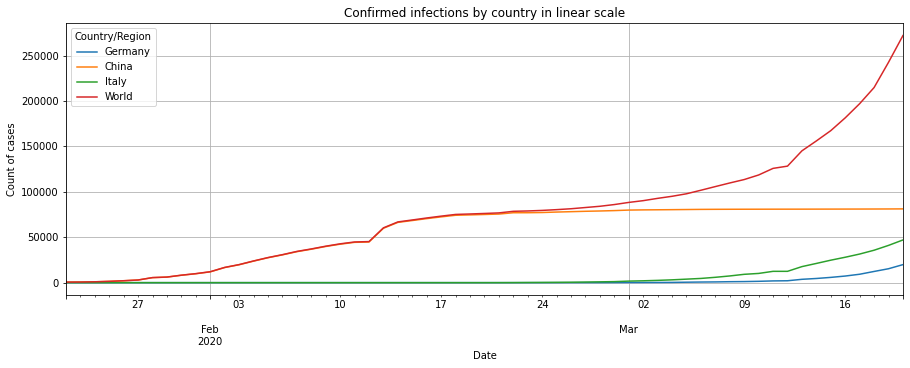

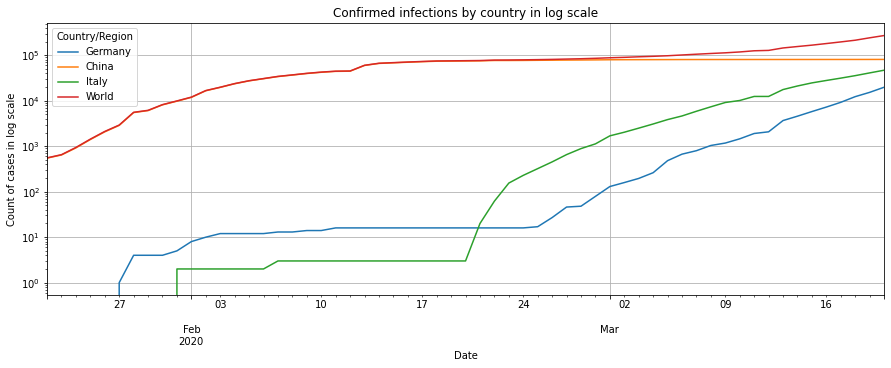

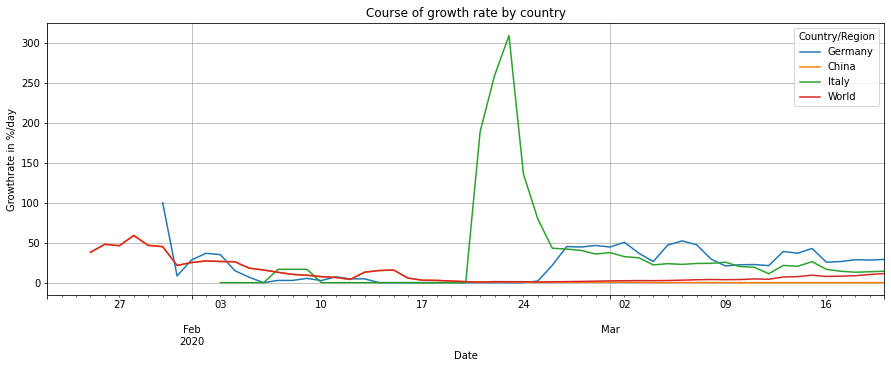

In [12]:
figure_size = (15,5)
str_timestamp = datetime.now().strftime('%Y%m%d')

ax0 = df_requested.plot(grid=True,title='Confirmed infections by country in linear scale',figsize=figure_size)
ax0.set_xlabel('Date')
ax0.set_ylabel('Count of cases');
plt.savefig(f'{str_timestamp}_covid_19_confirmed_infections_by_country_normal_scale.svg', format='svg', bbox_inches='tight')

ax1 = df_requested.plot(grid=True,logy=True,title='Confirmed infections by country in log scale',figsize=figure_size)
ax1.set_xlabel('Date')
ax1.set_ylabel('Count of cases in log scale');
plt.savefig(f'{str_timestamp}_covid_19_confirmed_infections_by_country_log_scale.svg', format='svg', bbox_inches='tight')

ax2 = df_requested_growthrate.plot(grid=True,title='Course of growth rate by country',figsize=figure_size)
ax2.set_xlabel('Date')
ax2.set_ylabel('Growthrate in %/day');
plt.savefig(f'{str_timestamp}_covid_19_daily_growthrate_by_country.svg', format="svg", bbox_inches='tight')

# Trying to aproximate a logistic model

In [13]:
import numpy as np
from lmfit import Model

In [14]:
def logistic(x,L,tau,x0):
    return L/(1+np.power(10,-(x-x0)/tau))

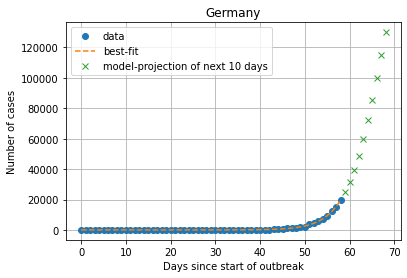

[[Model]]
    Model(logistic)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 149
    # data points      = 59
    # variables        = 3
    chi-square         = 621941.785
    reduced chi-square = 11106.1033
    Akaike info crit   = 552.520795
    Bayesian info crit = 558.753408
[[Variables]]
    L:    229139.392 +/- 97308.3768 (42.47%) (init = 1)
    tau:  8.75236121 +/- 0.17797670 (2.03%) (init = 1)
    x0:   66.9680669 +/- 1.92909413 (2.88%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(L, x0)   =  0.999
    C(tau, x0) =  0.955
    C(L, tau)  =  0.943

*********************************************************************



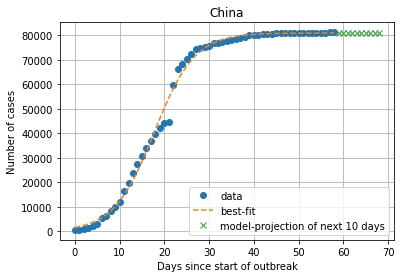

[[Model]]
    Model(logistic)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 71
    # data points      = 59
    # variables        = 3
    chi-square         = 2.5871e+08
    reduced chi-square = 4619895.99
    Akaike info crit   = 908.328123
    Bayesian info crit = 914.560735
[[Variables]]
    L:    80949.7583 +/- 436.785050 (0.54%) (init = 1)
    tau:  10.3743397 +/- 0.31099715 (3.00%) (init = 1)
    x0:   17.7611450 +/- 0.15609256 (0.88%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(L, x0)   =  0.466
    C(L, tau)  =  0.422
    C(tau, x0) =  0.194

*********************************************************************



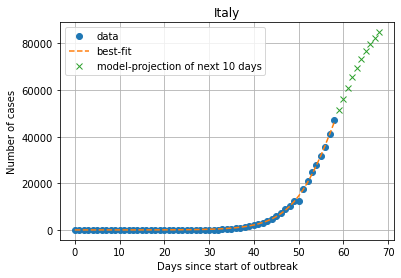

[[Model]]
    Model(logistic)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 87
    # data points      = 59
    # variables        = 3
    chi-square         = 9256794.56
    reduced chi-square = 165299.903
    Akaike info crit   = 711.836526
    Bayesian info crit = 718.069138
[[Variables]]
    L:    96457.2023 +/- 6258.49994 (6.49%) (init = 1)
    tau:  11.1592052 +/- 0.26843805 (2.41%) (init = 1)
    x0:   58.3859846 +/- 0.57015386 (0.98%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(L, x0)   =  0.996
    C(tau, x0) =  0.946
    C(L, tau)  =  0.923

*********************************************************************



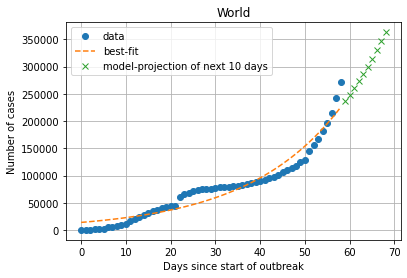

[[Model]]
    Model(logistic)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 1836
    # data points      = 59
    # variables        = 3
    chi-square         = 1.4251e+10
    reduced chi-square = 2.5449e+08
    Akaike info crit   = 1144.85231
    Bayesian info crit = 1151.08493
[[Variables]]
    L:    4.9420e+09 +/- 3.3794e+13 (683806.89%) (init = 1)
    tau:  48.4546841 +/- 7.73549322 (15.96%) (init = 1)
    x0:   268.320520 +/- 144527.118 (53863.61%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(L, x0)   =  1.000
    C(tau, x0) =  0.959
    C(L, tau)  =  0.959

*********************************************************************



In [15]:
num_projected_days = 10

model = Model(logistic)
country_models = dict()

for country in df_requested.columns:
    num_data_days = len(df_requested[country].values)
    x = np.arange(0,num_data_days)
    x_projected = np.arange(num_data_days,num_data_days+num_projected_days)
    y = df_requested[country].values
    params = model.make_params(L=1,tau=1,x0=1)
    result = model.fit(y, params, x=x)
    y_projection = model.eval(result.params, x=x_projected)
    country_models[country] = {'params':params, 'result':result}
    result.plot_fit(datafmt='o',fitfmt='--')
    plt.title(country)
    plt.plot(x_projected, y_projection,'x',label=f'model-projection of next {num_projected_days} days')
    plt.legend();
    plt.xlabel('Days since start of outbreak')
    plt.ylabel('Number of cases')
    plt.ticklabel_format(style='plain')
    plt.grid(True)
    #plt.text(3, 8, result.fit_report(), style='italic', bbox={'alpha': 0.5, 'pad': 10})
    plt.show()
    print(result.fit_report())    
    print('\n*********************************************************************\n')

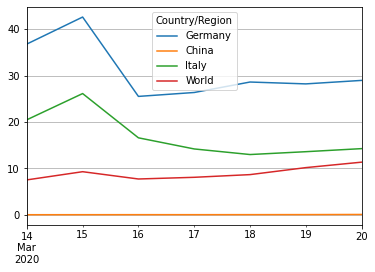

In [16]:
df_requested_growthrate.last('7D').plot(grid=True)

In [17]:
df_requested.tail()

Country/Region,Germany,China,Italy,World
2020-03-16,7272,81033,27980,181527
2020-03-17,9257,81058,31506,197142
2020-03-18,12327,81102,35713,214910
2020-03-19,15320,81156,41035,242708
2020-03-20,19848,81250,47021,272166


In [18]:
df_requested_growthrate.tail()

Country/Region,Germany,China,Italy,World
2020-03-16,25.546599,0.036226,16.611467,7.729919
2020-03-17,26.391457,0.033332,14.211483,8.094615
2020-03-18,28.649354,0.040723,13.006360,8.674699
2020-03-19,28.246869,0.050572,13.619002,10.183179
2020-03-20,29.000088,0.078897,14.280899,11.361576
